In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import scipy.stats
import seaborn as sns

from gnn_testbed.event_generation import (
    Detector,
    proposal_setup,
    generate_cascade,
    make_line
)

from gnn_testbed.plotting import plot_events, plot_event
from gnn_testbed.feature_generation import get_features


In [2]:
dfs = pd.read_pickle("statistics.p")

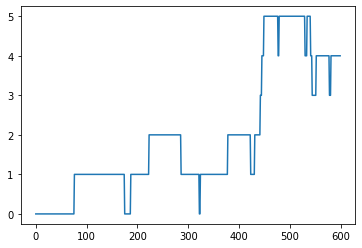

In [3]:
plt.plot([df["is_emitting"].sum() for df in dfs])

(1, 10000000000.0)

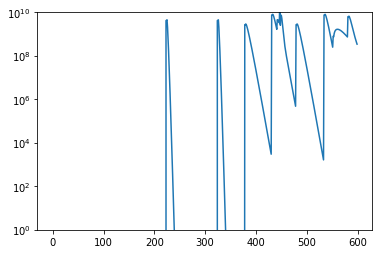

In [4]:
plt.plot([df["photons"].sum() for df in dfs])

mask = [df["photons"].sum() > 0 for df in dfs]
plt.semilogy()
plt.ylim(1, 1E10)

In [5]:
ix = np.argwhere(mask).ravel()[0]
dfs[ix][dfs[ix]["is_emitting"]]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,...,pulse mean,pulse sd,pulse size,pulse start,is_emitting,emission_duration,encounter photons,shear photons,photons,is_injected
15,long pulse 1,18.47981,7.894448,0.0,0.0,0.000586,0.6148,True,-0.871640,0.2,...,2.0,1.5,1.000000e+10,False,True,63.0,0.0,-1.743281e+09,-3.140551e-04,True
24,Bathyctena chuni (Moser),2.72431,7.594436,0.0,0.0,0.000780,0.8001,True,5.810912,0.2,...,2.0,1.0,1.000000e+10,True,True,99.0,0.0,1.162182e+10,4.194248e+09,True


In [6]:
dfs[ix][dfs[ix]["is_emitting"] & (dfs[ix]["photons"] > 0)]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,...,pulse mean,pulse sd,pulse size,pulse start,is_emitting,emission_duration,encounter photons,shear photons,photons,is_injected
24,Bathyctena chuni (Moser),2.72431,7.594436,0.0,0.0,0.00078,0.8001,True,5.810912,0.2,...,2.0,1.0,1.000000e+10,True,True,99.0,0.0,1.162182e+10,4.194248e+09,True


In [8]:
rng = np.random.RandomState(31338)
modules = make_line(0, 0, 30, 10, rng, 1e-6, 0)
modules += make_line(100, 0, 30, 10, rng, 1e-6, 0)
det = Detector(modules)

In [28]:
biosim_det_pos = [3, 7.35]

events = []
records = []
for ix in np.argwhere(mask).ravel():
    active = dfs[ix]["is_emitting"] & (dfs[ix]["photons"] > 0)

    for _, organism in dfs[ix][active].iterrows():
        pos = np.asarray([organism["pos_x"], organism["pos_y"], 100])
        t0 = ix * 1E9
        
        mean = organism["pulse mean"]
        sd = organism["pulse sd"]
        beta = mean / sd**2.
        alpha = mean**2. / sd**2.
        # scipy parameters
        shape = alpha
        scale = 1. / beta
        gamma_dist = scipy.stats.gamma(
            shape,
            scale=scale
        )
        total_window = gamma_dist.cdf(1E-4) * organism["pulse size"]
        print(np.exp(gamma_dist.logcdf(1E-4)))
        times = gamma_dist.rvs(100)
        amps = gamma_dist.pdf(times)
        amps = (amps / np.sum(amps)) * total_window
        print(amps)
        
        for t, amp in zip(times, amps):
            event, record = generate_cascade(det, pos, t0+t, n_photons=amp)
            events.append(event)
            records.append(records)
            


        
        
        
        #plt.plot(organism[1]["pos_x"], organism[1]["pos_y"], "ok")
    break




6.665600088883814e-17
[8.66988485e-09 3.74932869e-09 8.65340439e-09 7.68990983e-09
 6.92310460e-09 5.22236567e-09 8.02689372e-09 5.96219046e-09
 6.34167529e-09 6.36524499e-09 7.76644005e-09 4.34993034e-09
 4.87025188e-09 7.42675222e-09 3.35651272e-09 8.53467362e-09
 1.87222383e-09 8.65760497e-09 2.64058193e-09 4.79489350e-09
 8.72318215e-09 6.49754962e-09 3.31924453e-09 8.24088099e-09
 4.38499788e-09 3.24888463e-09 5.57655535e-09 7.82226255e-09
 6.53435841e-09 8.73206228e-09 8.32780203e-09 7.53348966e-09
 6.82477339e-09 8.61964667e-09 6.73154217e-09 6.13404330e-09
 8.11901340e-09 4.18031999e-09 7.86001659e-09 8.43977013e-09
 1.45976484e-10 5.25941919e-09 3.52240515e-09 7.00590577e-09
 8.58291359e-09 8.49098696e-09 8.69865395e-09 3.89398384e-09
 7.32905110e-09 7.96853801e-09 7.42713746e-09 8.35514087e-09
 8.43359426e-09 8.71078065e-09 6.05384547e-09 7.45758641e-09
 2.60473660e-09 8.34339916e-09 7.24231432e-09 4.91903092e-09
 7.81823034e-09 7.06755188e-09 8.42170417e-09 8.56576640e-09
 8

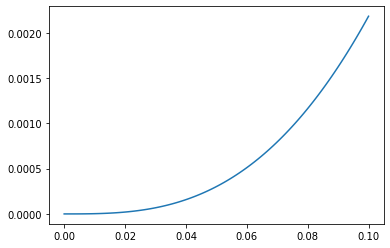

In [31]:
mean = 2
sd = 1
beta = mean / sd**2.
alpha = mean**2. / sd**2.
# scipy parameters
shape = alpha
scale = 1. / beta
gamma_dist = scipy.stats.gamma(
    shape,
    scale=scale
)

xs = np.linspace(0, 1E-1, 100)
plt.plot(xs, gamma_dist.pdf(xs))

In [24]:
event = ak.sort(ak.concatenate(events, axis=1))

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning:

divide by zero encountered in log10



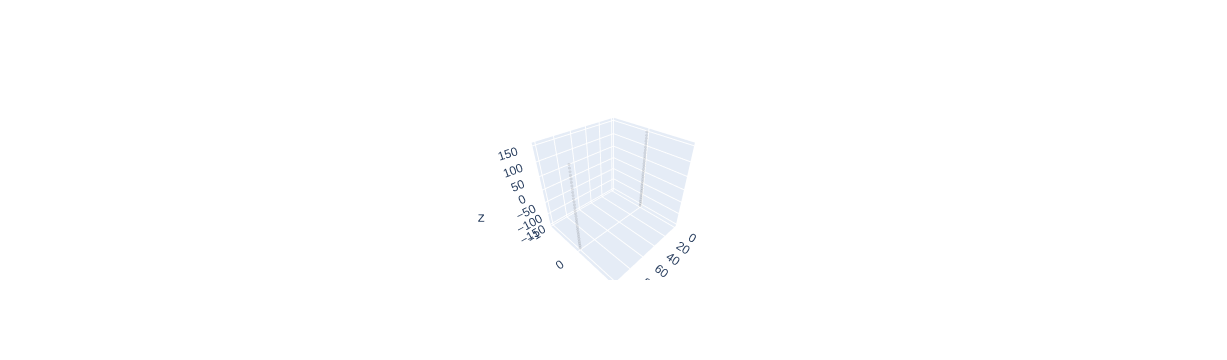

In [25]:
plot_event(det, event)

In [21]:
event[20]

<Array [2.23e+11, 2.23e+11, ... 2.23e+11] type='5395 * float64'>

<AxesSubplot:ylabel='Count'>

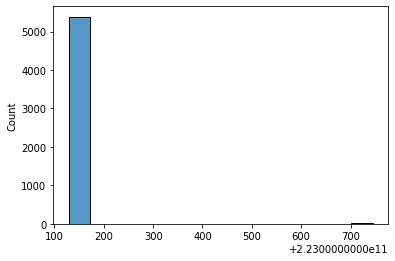

In [22]:
sns.histplot(np.asarray(event[20]))

In [86]:
np.asarray(event[1]).min()- np.asarray(event[1]).max()


-3.202911376953125

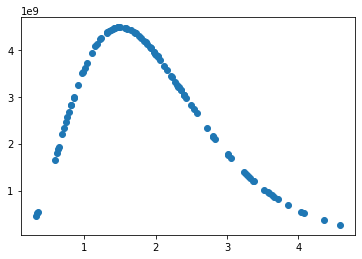

In [69]:
plt.plot(times, amps, "o")